# Deep Learning for Time Series: Forecasting, Anomaly Detection, and Representation Learning

This project provides a comprehensive, modular framework for time series forecasting, anomaly detection, and representation learning using deep learning techniques. The implementation leverages LSTM and convolutional autoencoder architectures to address real-world time series analysis challenges in a scalable and reproducible manner.

## Project Objectives
- Develop robust models for time series forecasting using LSTM networks
- Detect anomalies in time series data with LSTM autoencoders
- Learn compact representations of time series using convolutional autoencoders
- Provide clear, reproducible experiments and visualizations

## Notebook Structure
1. Theoretical Background
2. Data Preparation and Utilities
3. LSTM Forecasting
4. LSTM Anomaly Detection
5. Convolutional Autoencoding
6. Experimental Results & Discussion

---

## Theoretical Background

### Time Series Analysis
Time series data consists of sequences of values measured over time. Analyzing such data is crucial in finance, engineering, and science for forecasting, anomaly detection, and pattern discovery.

### LSTM Networks
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data. They are widely used for time series forecasting due to their ability to model temporal patterns and handle vanishing gradient problems.

### Autoencoders
Autoencoders are neural networks trained to reconstruct their input. LSTM autoencoders are effective for sequence reconstruction and anomaly detection, while convolutional autoencoders can learn compressed representations of time series for clustering and retrieval.

---

Loading libraries and the time series dataset.

In [ ]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector, Reshape
from keras.models import Model
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from google.colab import files

#load input dataframe
df = pd.read_csv("/content/drive/MyDrive/project algorithms/Datasets/3η εργασία/nasdaq2007_17.csv", '\t', header=None, index_col=0)

## Common Utility Functions

The following functions support data preprocessing, scaling, vectorization, and visualization. They are used throughout the notebook to ensure modularity and code reuse.


In [ ]:
#create X and Y vectorized sets through shifting
#use in forecasting and anomaly detection
def vectorize(serie, time_steps):
    X = []
    Y = []

    for i in range(time_steps, len(serie)):
        X.append(serie[i-time_steps:i, 0])
        Y.append(serie[i, 0])

    return np.array(X), np.array(Y)

#split input time serie to training and test series
#perform scaling, vectorization and reshaping
def split_serie(time_serie, scaler, train_serie_len, time_steps):
    Serie_train = time_serie.iloc[:train_serie_len]
    Serie_test = time_serie.iloc[train_serie_len - time_steps:]

    Serie_train = scaler.fit_transform(Serie_train)
    Serie_test = scaler.transform(Serie_test)

    X_train, Y_train = vectorize(Serie_train, time_steps)
    X_test, Y_test = vectorize(Serie_test, time_steps)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return (X_train, Y_train, X_test, Y_test)

#plot train-validation losses collected during training
def plot_training_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#concatenate all sets from preprocessed time series
#final scheme: (X_train, Y_train, X_test, Y_test) containing all time series data 
def group_sets(all_sets):
    grouped_sets = list(all_sets[0])
    for single_set in all_sets[1:]:
        for index in range(len(single_set)):
            grouped_sets[index] = np.concatenate((grouped_sets[index],single_set[index]))
    return grouped_sets

## Time Series Forecasting with LSTM

LSTM networks are well-suited for time series forecasting due to their ability to learn temporal dependencies. In this section, we build and evaluate LSTM models to predict future values of stock time series.

### Helper Functions

These functions support model training, evaluation, and visualization for forecasting experiments.

In [ ]:
#predict and plot forecast results
def forecast(model, scaler, X_test, Y_test, train_serie_len, time_serie_len):
    Pred_test = model.predict(X_test)
    Pred_test = scaler.inverse_transform(Pred_test)
    Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

    plt.figure(figsize=(10,10))
    plt.plot(range(train_serie_len, time_serie_len), Y_test, color = 'red', label = 'Validating Time Serie')
    plt.plot(range(train_serie_len, time_serie_len), Pred_test, color = 'blue', label = 'Forecasting Time Serie')
    plt.title('Time Series Forecasting')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### The Final Model

After extensive experimentation, the following hyperparameters were selected for the LSTM forecasting model to achieve optimal performance while avoiding overfitting:

* time_steps = 60
* epochs = 20
* batch_size = 128
* layers = 9
* units per layer = 64

In [ ]:
time_steps = 60
epochs = 20
batch_size = 128
split_percentage = 0.8
online_training = False
n = 10

model = Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape = (time_steps, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

time_serie_len  = df.shape[1]
train_serie_len = int(time_serie_len * split_percentage)
scaler          = MinMaxScaler(feature_range=(0,1))

### Training on All Time Series

The model is trained on the combined data from all selected time series, allowing it to learn general temporal patterns across the dataset.

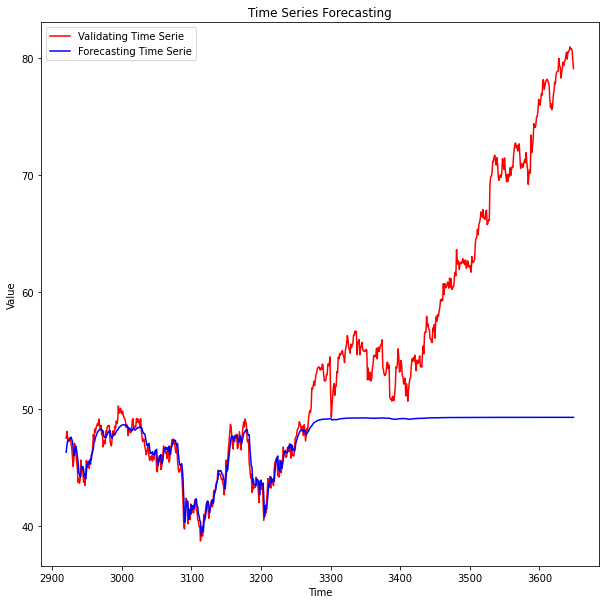

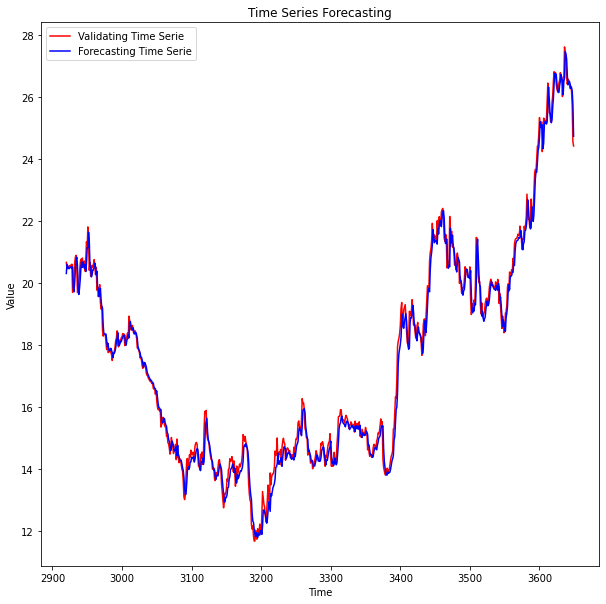

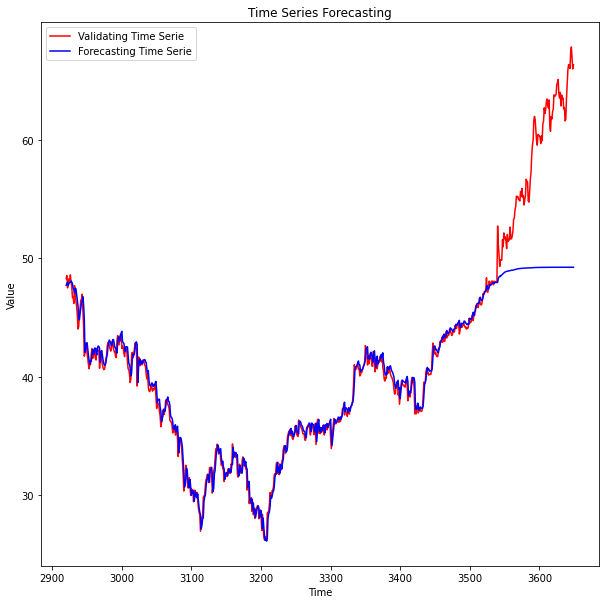

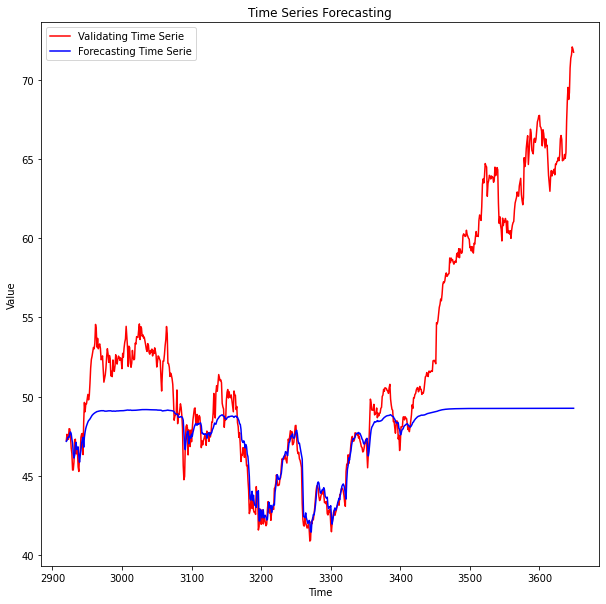

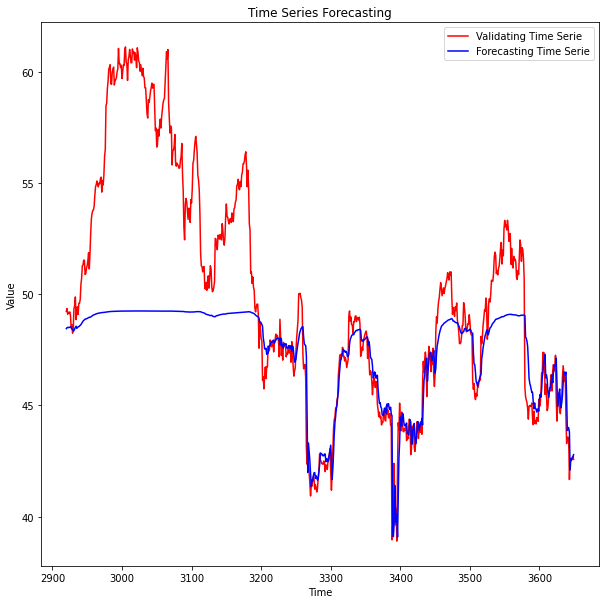

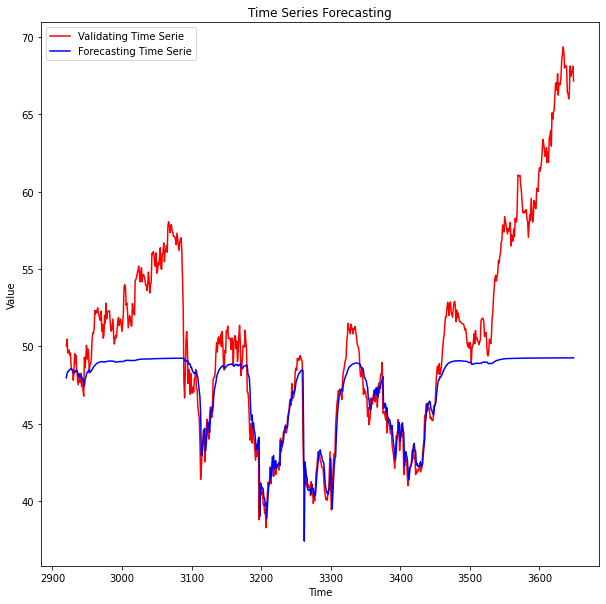

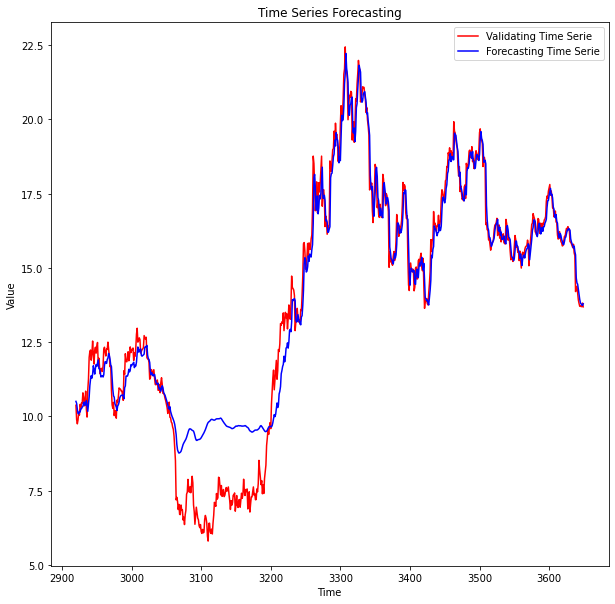

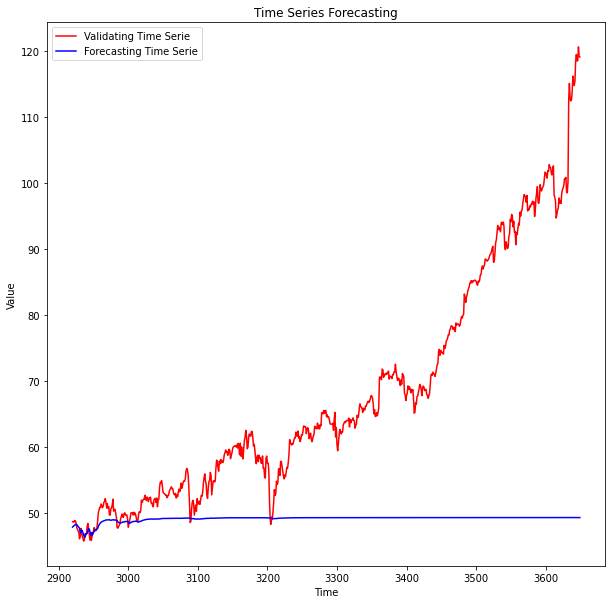

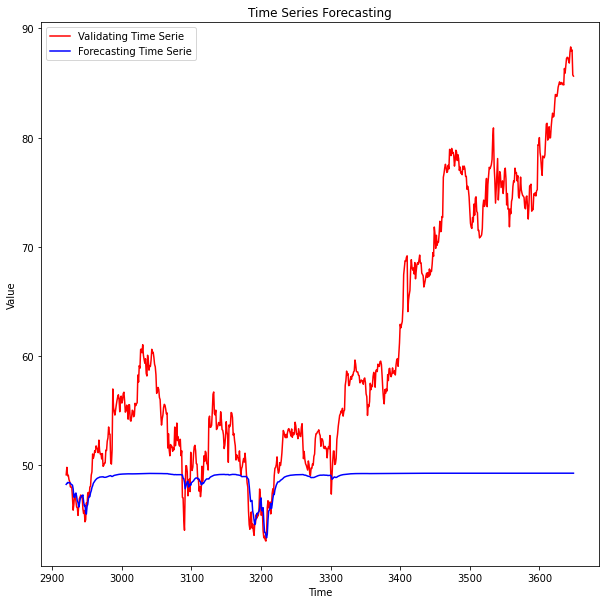

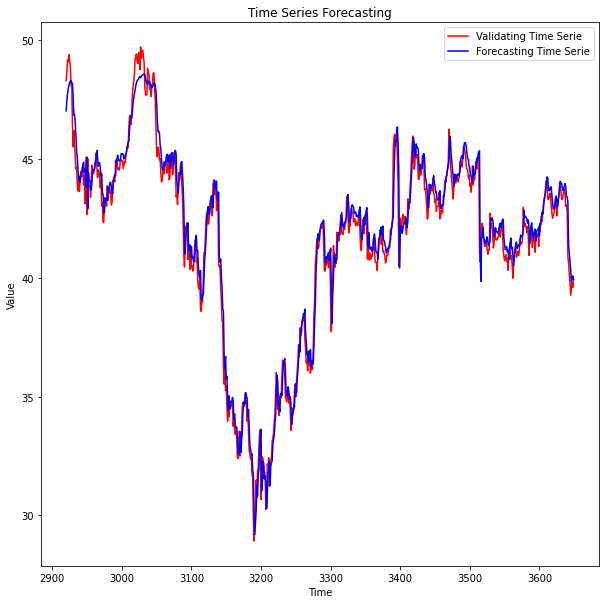

In [ ]:
#all_sets contains objs of type (X_train, Y_train, X_test, Y_test) of time series
all_sets = []

#fill all_sets
for serie_index in range(n):
    time_serie = pd.DataFrame(np.array(df.iloc[serie_index]),columns=[df.index[serie_index]])
    all_sets.append(split_serie(time_serie, scaler, train_serie_len, time_steps))

#train the model on current execution
if online_training:

    #concatenate all sets
    (X_train,Y_train,X_test,Y_test) = group_sets(all_sets)

    history = model.fit(
        X_train, Y_train,
        epochs = epochs, 
        batch_size = batch_size, 
        validation_data=(X_test,Y_test)
        )
    
    #plot train and validation losses from previous fit
    plot_training_loss(history)

    #save and download model
    model.save("forecasting")
    !zip -r /content/forecasting.zip /content/forecasting
    files.download("/content/forecasting.zip")

#load an offline model
else:
    model = keras.models.load_model("forecasting")

#predict and plot forecast results for test sets
for (_, _, X_test, Y_test) in all_sets[:10]:
    forecast(model, scaler, X_test, Y_test, train_serie_len, time_serie_len)

keras.backend.clear_session()

### Training Per Time Series

Alternatively, the model can be trained separately on each time series, enabling it to specialize for individual patterns and behaviors.

In [ ]:
#can only be online
for serie_index in range(n):

    #get time serie
    time_serie = pd.DataFrame(np.array(df.iloc[serie_index]),columns=[df.index[serie_index]])
    
    #split time serie to sets
    X_train, Y_train, X_test, Y_test = split_serie(time_serie, scaler, train_serie_len, time_steps)
    
    #train the model
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_test,Y_test))
    
    #plot train and validation losses from previous fit
    plot_training_loss(history)

    #predict and plot forecast results
    forecast(model, scaler, X_test, Y_test, train_serie_len, time_serie_len)
    
    keras.backend.clear_session()

## LSTM-based Anomaly Detection in Time Series

LSTM autoencoders can reconstruct normal time series patterns. Significant reconstruction errors indicate potential anomalies. This section demonstrates how to use LSTM autoencoders for unsupervised anomaly detection.

### Helper Functions

These functions support anomaly detection by reconstructing sequences and visualizing detected anomalies.

In [ ]:
#predict and plot anomalies
def detect_anomalies(model, X_test, Y_test, train_serie_len, time_serie_len, threshold):
    Pred_test = model.predict(X_test)
    Loss_test = np.mean(np.abs(Pred_test - X_test), axis=1)

    anomaly_index = np.where(Loss_test > threshold)[0]
    anomaly_value = Y_test[anomaly_index]
    anomaly_index += train_serie_len

    plt.figure(figsize=(10,10))
    plt.plot(range(train_serie_len,time_serie_len),Y_test, color = 'red', label = 'Time Serie')
    plt.scatter(anomaly_index, anomaly_value, color = 'blue', label = 'Anomalies')
    plt.title('Time Series Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### The Final Model

The following hyperparameters were selected for the LSTM autoencoder to balance detection accuracy and computational efficiency:

* time_steps = 60
* epochs = 20
* batch_size = 128
* layers = 6
* units per layer = 32

In [ ]:
time_steps = 60
epochs = 20
batch_size = 128
split_percentage = 0.8
online_training = False
threshold = 0.65
n = 10

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=32,
    input_shape=(time_steps,1),
    activation="relu"
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=time_steps))
model.add(keras.layers.LSTM(units=32, return_sequences=True, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=32, return_sequences=True, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=32, return_sequences=True, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=32, return_sequences=True, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=32, return_sequences=True, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=1)
  )
)
model.compile(loss='mae', optimizer='adam')

time_serie_len  = df.shape[1]
train_serie_len = int(time_serie_len * split_percentage)
scaler          = MinMaxScaler(feature_range=(0,1))

### Training on All Time Series

The autoencoder is trained on the combined data from all time series, learning to reconstruct normal patterns and flagging deviations as anomalies.

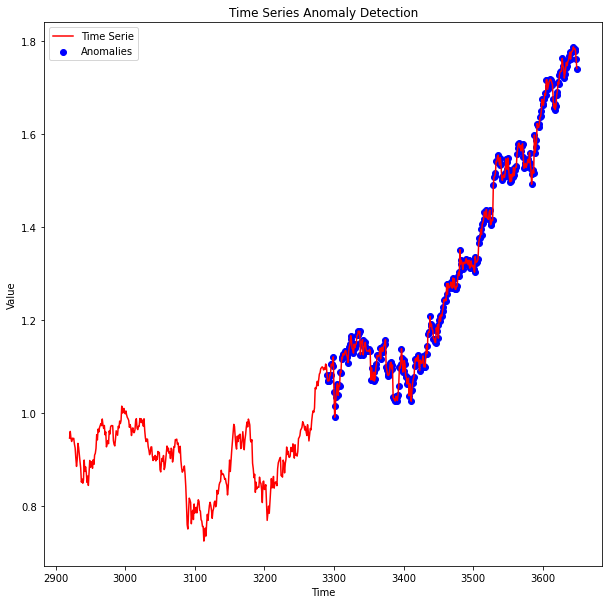

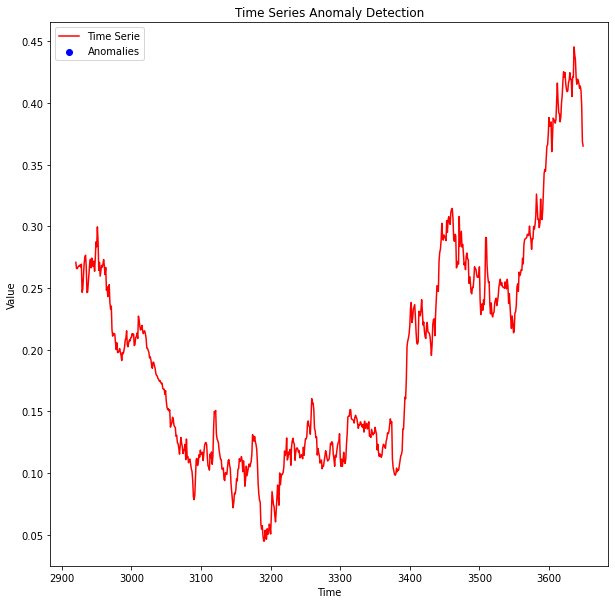

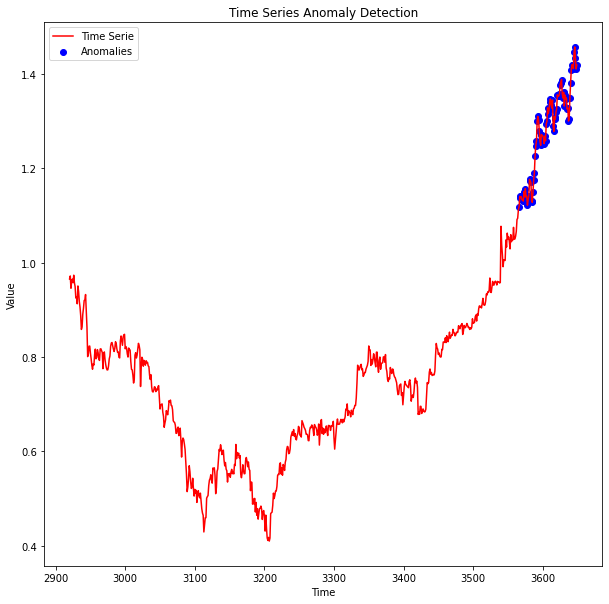

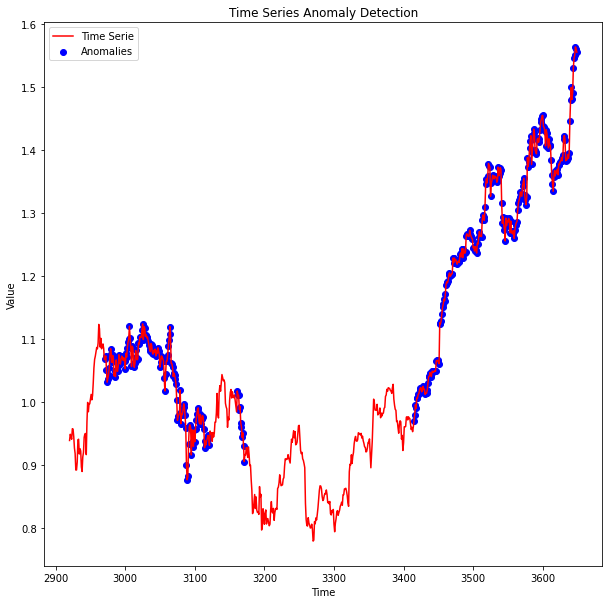

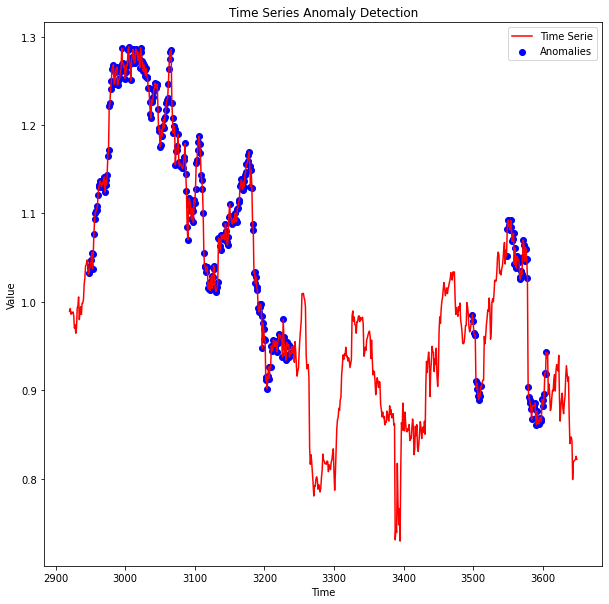

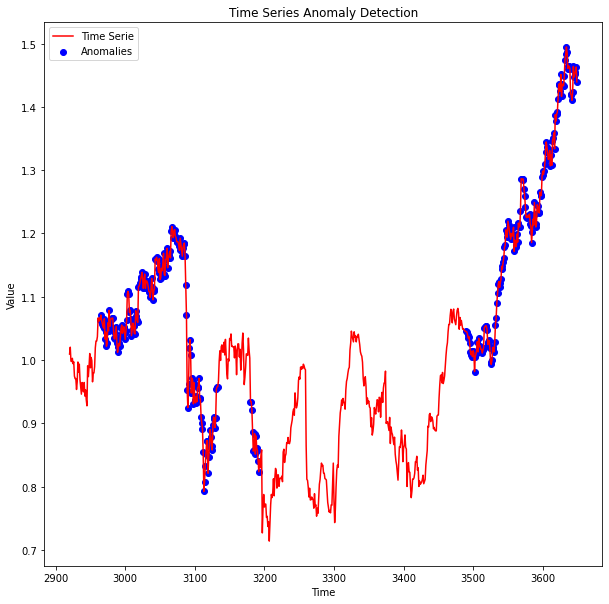

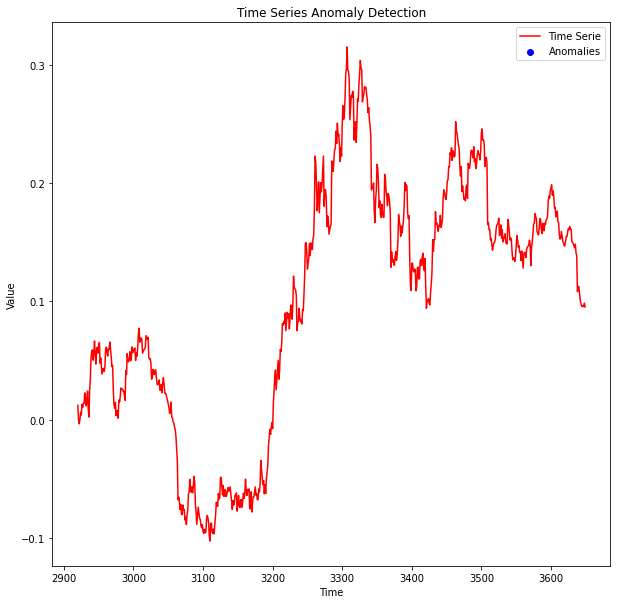

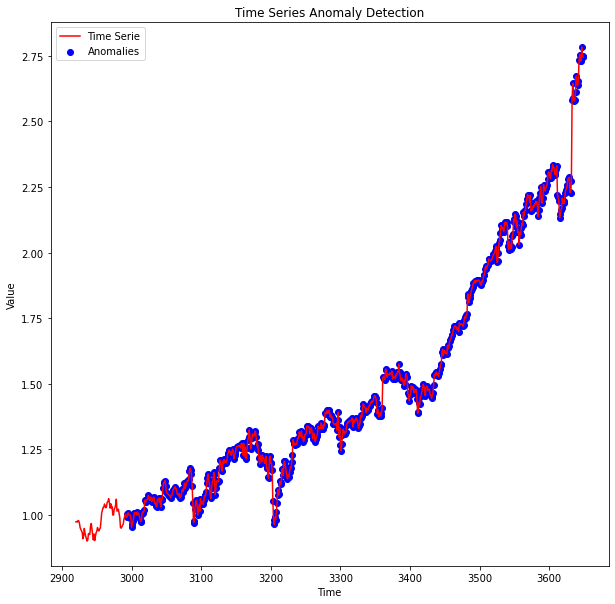

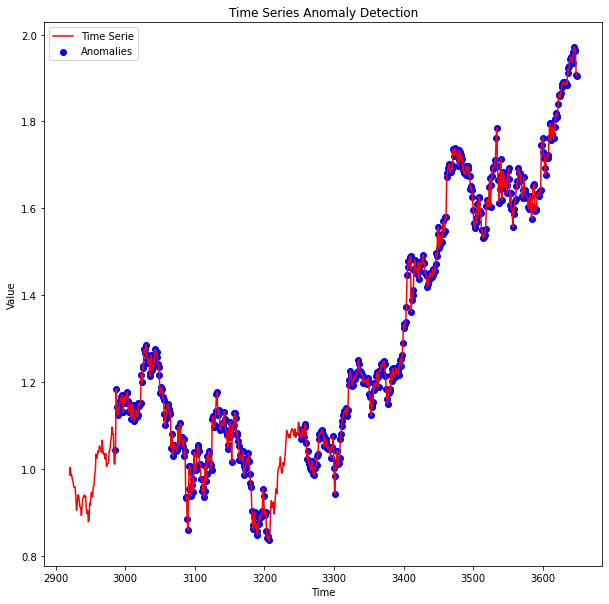

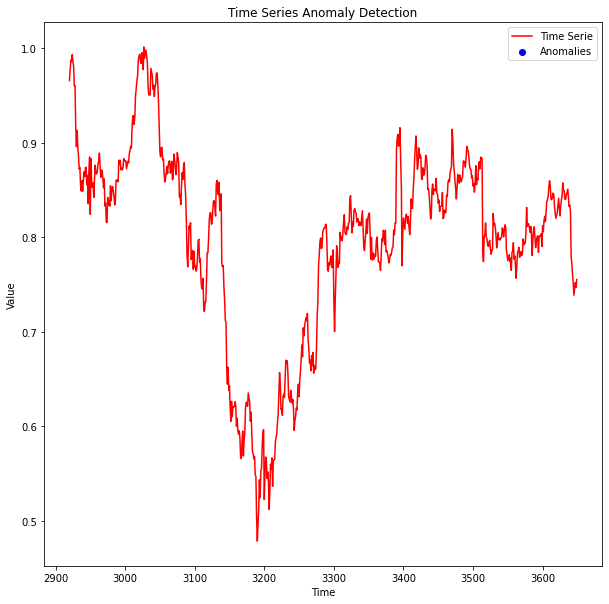

In [ ]:
#all_sets contains objs of type (X_train, Y_train, X_test, Y_test) of time series
all_sets = []

#fill all_sets
for serie_index in range(n):
    time_serie = pd.DataFrame(np.array(df.iloc[serie_index]),columns=[df.index[serie_index]])
    all_sets.append(split_serie(time_serie, scaler, train_serie_len, time_steps))


#train the model on current execution
if online_training:

    #concatenate all sets
    (X_train, Y_train, X_test, Y_test) = group_sets(all_sets)

    history = model.fit(
        X_train, Y_train, 
        epochs = epochs, 
        batch_size = batch_size, 
        validation_data=(X_test,Y_test)
        )
    
    #plot train and validation losses from previous fit
    plot_training_loss(history)

    #save and download model
    model.save("anomaly_detection")
    !zip -r /content/anomaly_detection.zip /content/anomaly_detection
    files.download("/content/anomaly_detection.zip")

#load an offline model
else:
    model = keras.models.load_model("anomaly_detection")

#predict and plot anomaly detection results for test sets
for (_, _, X_test, Y_test) in all_sets:
    detect_anomalies(model, X_test, Y_test, train_serie_len, time_serie_len, threshold)

keras.backend.clear_session()

## Convolutional Autoencoding for Time Series Representation

Convolutional autoencoders learn compressed representations of time series by encoding and decoding input sequences. These representations can be used for clustering, similarity search, and visualization of complex time series data.

### Helper Functions

These functions support windowing, scaling, encoding, and visualization for the autoencoding experiments.

In [ ]:
#create X set through windowing/dividing the time serie
def windowing(serie, window_size):
    X=[]

    for i in range(window_size, len(serie), window_size):
        X.append(serie[i-window_size:i, 0])

    return np.array(X)
    
#split serie to training and test serie
#perform scaling and windowing
def split_serie_convolutions(time_serie, scaler, train_serie_len, window_length):
    Serie_train = time_serie.iloc[:train_serie_len]
    Serie_test = time_serie.iloc[train_serie_len - window_length:]
    Y_test = time_serie.iloc[train_serie_len:]

    Serie_train = scaler.fit_transform(Serie_train)
    Serie_test = scaler.transform(Serie_test)

    X_train = windowing(Serie_train, window_length)
    X_test = windowing(Serie_test, window_length)

    return (X_train, X_test)

#predict and plot encoded and decoded time serie
def compare_training_results(encoder, autoencoder, X_test):
    Pred_encode_test = encoder.predict(X_test)
    Pred_decode_test = autoencoder.predict(X_test)

    X_test = [item for list_ in X_test for item in list_]
    Pred_encode_test = [item for list_ in Pred_encode_test for item in list_]
    Pred_decode_test = [item for list_ in Pred_decode_test for item in list_]

    plt.figure(figsize=(10,10))
    plt.plot(range(len(X_test)),X_test, color = 'red', label = 'Validating Time Serie')
    plt.plot(range(len(Pred_encode_test)),Pred_encode_test, color = 'green', label = 'Encoded Time Serie')
    plt.plot(range(len(Pred_decode_test)),Pred_decode_test, color = 'blue', label = 'Decoded Time Serie')
    plt.title('Time Series Compression')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### The Final Model

The following hyperparameters were selected for the convolutional autoencoder to achieve effective compression and reconstruction of time series:

* window_length = 50
* epochs = 100
* batch_size = 32
* layers = 3 downsampling - 3 upsampling
* intermediate filter size = 16
* latent dimension = 7

In [ ]:
#split initial dataframe to dataset and queryset
dataset = df.iloc[:350]
queryset = df.iloc[350:]

#output filenames
dataset_comp_filename = "comp_dataset.csv"
queryset_comp_filename = "comp_queryset.csv"

#hyperparameters
window_length = 50
epochs = 100
batch_size = 32

split_percentage = 0.8
n, time_serie_len = df.shape
online_training = False

#the model layers
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window)
x = MaxPooling1D(2, padding="same")(x)
x = Conv1D(16, 3, activation="relu", padding="same")(x)
x = MaxPooling1D(2, padding="same")(x)
x = Conv1D(1, 3, activation="relu", padding="same")(x)
encoded = MaxPooling1D(2, padding="same")(x)

#the encoder produced
encoder = Model(input_window, encoded)

x = Conv1D(1, 3, activation="relu", padding="same")(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(16, 2, activation='relu')(x)
x = UpSampling1D(2)(x)
x = Conv1D(16, 2, activation='relu')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)

#the autoencoder produced
autoencoder = Model(input_window, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

train_serie_len = int(time_serie_len * split_percentage)
scaler          = MinMaxScaler(feature_range=(0,1))


#train the model on current execution
if online_training:
    all_sets = []

    #fill all_sets
    for serie_index in range(0,n):
        time_serie = pd.DataFrame(np.array(df.iloc[serie_index]),columns=[df.index[serie_index]])
        all_sets.append(split_serie_convolutions(time_serie, scaler, train_serie_len, window_length))

    #concatenate all sets
    (X_train, X_test) = group_sets(all_sets)
    
    history = autoencoder.fit(
        X_train, X_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_test, X_test)
        )
    
    #plot train and validation losses from previous fit
    plot_training_loss(history)

    #predict and plot encoded and dedoded time serie
    for (_, X_test) in all_sets[:10]:
        compare_training_results(encoder, autoencoder, X_test)

    #save and download models
    encoder.save("encoder")
    autoencoder.save("autoencoder")
    !zip -r /content/encoder.zip /content/encoder
    !zip -r /content/autoencoder.zip /content/autoencoder
    files.download("/content/encoder.zip")
    files.download("/content/autoencoder.zip")

#load an offline model
else:
    encoder = keras.models.load_model("encoder")
    autoencoder = keras.models.load_model("autoencoder")

#generate dataset and queryset
for cur_df in [(dataset, dataset_comp_filename), (queryset, queryset_comp_filename)]:
    
    #will contain the final output
    compressed_output = pd.DataFrame()

    for serie_index in range(cur_df[0].shape[0]):

        #the time serie id
        output_index = cur_df[0].index[serie_index]
        
        #get the time serie
        time_serie = pd.DataFrame(np.array(cur_df[0].iloc[serie_index]),columns=[output_index])
        
        #scale the time seire
        time_serie = scaler.fit_transform(time_serie)
        
        #divide the time serie into convolutions
        time_serie = windowing(time_serie, window_length)
        
        #generate the encoded time serie
        time_serie = encoder.predict(time_serie)
        time_serie = time_serie.flatten()

        #initialize the column headers (first time only)
        if (len(compressed_output.columns)==0):
            compressed_output = pd.DataFrame(columns=range(time_serie.shape[0]))
        
        #add the new encoded time serie
        compressed_output.loc[output_index] = time_serie

    #export to csv and download
    compressed_output.to_csv(cur_df[1], sep='\t', header=False)
    files.download("/content/"+cur_df[1])

keras.backend.clear_session()

# Experimental Results and Discussion

This section summarizes the key findings from the experiments, discusses the impact of hyperparameters, and interprets the practical value of the models for real-world time series analysis.

## Time Series Forecasting
Experiments were conducted with various hyperparameters (batch size, layers, units, time steps) for training LSTM forecasting models. The appropriate number of epochs was selected based on the loss plot (train/test loss) to avoid overfitting. The final model selected had:
- time_steps = 60
- epochs = 20
- batch_size = 128
- layers = 9
- units per layer = 64

It was observed that increasing the batch size significantly reduced execution time, but very large batch sizes (>1024) did not further minimize loss. Increasing the number of units per layer improved the error, while the number of layers and time_steps did not significantly affect the final loss.

## Time Series Anomaly Detection
LSTM autoencoders with dropout were used to prevent overfitting. Experiments showed that:
- Increasing the number of layers reduced error, requiring more complex models.
- The number of units per layer had less impact on loss.
- The final model: time_steps = 60, epochs = 20, batch_size = 128, layers = 6, units per layer = 32.

## Convolutional Autoencoding of Time Series
Convolutional autoencoders were used for compression and representation. Experiments showed:
- Changing the number of layers significantly affected loss.
- The number of units and window length had less impact on loss.
- The final model: window_length = 50, epochs = 100, batch_size = 32, 3 downsampling/3 upsampling layers, filter size = 16, latent dimension = 7.

## Conclusions
Hyperparameters were selected for optimal validation performance and to avoid overfitting. The final models offer a good balance between accuracy and computational efficiency. The results and plots confirm the effectiveness of the approaches for forecasting, anomaly detection, and time series compression.